In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv("../data/casino.csv")
true_x = np.array(df["x"])
y = np.array(df["y"])


Hidden Markov model:

\begin{align}
x_1 &\sim \mu(\cdot) \\
x_t | x_{t-1} &\sim p(\cdot|x_{t-1}) \\
y_t | x_t &\sim p(\cdot | x_t).
\end{align}

Filtering: compute $\alpha_t(j) = p(x_t = j | y_{1:t})$.

One-step prediction: $\alpha_{t|t-1}(j) = p(x_t = j | y_{1:t-1})$.

The recursion is given by,

\begin{align}
p(x_t | y_{1:t}) &= \frac{p(x_t, y_t | y_{1:t-1})}{p(y_t | y_{1:t-1})} \\
&= \frac{p(y_t | x_t) p(x_t | y_{1:t-1})}{p(y_t | y_{1:t-1})} \\
&= \frac{B_{x_t,y_t} \alpha_{t|t-1}(x_t)}{p(y_t | y_{1:t-1})}.
\end{align}

\begin{align}
    p(y_t | y_{1:t-1}) &= \sum_{x_t=0}^{1} p(y_t | x_t) p(x_t | y_{1:t-1}) \\
    &= \sum_{x_t=0}^{1} B_{x_t,y_t} \alpha_{t|t-1}(x_t).
\end{align}

Note: $\alpha_{t|t-1}(j) = \sum_{i=0}^{1} p(x_t = j, x_{t-1} = i | y_{1:t-1}) = \sum_{i=0}^{1} p(x_t = j | x_{t-1} = i) p(x_{t-1} = i | y_{1:t-1})$.

So, $\alpha_{t|t-1}(j) = \sum_{i} A_{ij} \alpha_{t-1}(i) = A^T \alpha_{t-1}$.

And therefore, in matrix form:

$$\alpha_t = \text{Normalize}(B_{y_t} \odot (A^T \alpha_{t-1})).$$

The algorithm has, 

1. prediction step where we compute $\alpha_{t|t-1}$;
2. update step where we compute $\alpha_t$;
3. marginalization step compute and save $m_t = p(y_t | y_{1:t-1})$.

Base case $t = 1$: compute

- $\alpha_{1|0}(j) = p(x_1 = j | \emptyset) = \mu(j)$;
- $\tilde{\alpha}_1(j) = B_{j,y_t} \alpha_{1|0}(j) = B_{j,y_t} \mu(j)$;
- $\alpha_1(j) = \tilde{\alpha}_1(j) / \sum_i \tilde{\alpha}_1(j)$.

For $t > 1$: compute

- $\alpha_{t|t-1} = p(x_t = j | y_{1:t-1}) = A^T \alpha_{t-1}$.
- $\alpha_t = \text{Normalize}(B \odot (A^T \alpha_{t-1}))$.

$m_t = p(y_t | y_{1:t-1})$

$\log p(y_{1:T}) = \sum_t \log p(y_{t} | y_{1:t-1})$

In [56]:
chain_length = y.shape[0]
K = 2
alpha = np.zeros((K, chain_length))
alpha_pred = np.zeros((K, chain_length))
marginals = np.zeros(chain_length)

In [87]:
# Generate some data.
mu = np.array([0.5, 0.5])
print(mu)
A = np.array([[0.9, 0.1], [0.2, 0.8]])
print(A)
fair_die = np.ones(6)/6.
loaded_die = np.ones(6)/10.
loaded_die[5] = 5/10.
B = np.row_stack((fair_die, loaded_die))
print(B)

[0.5 0.5]
[[0.9 0.1]
 [0.2 0.8]]
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]


In [88]:
alpha_pred[:,0] = mu
unnorm = B[:,y[0]-1] * alpha_pred[:,0]
alpha[:,0] = unnorm / unnorm.sum()
print(y[0])
alpha[:,0]

for t in range(1, chain_length):
    alpha_pred[:,t] = A.T @ alpha[:,t-1]
    unnorm = B[:,y[t]-1] * alpha_pred[:,t]
    alpha[:,t] = unnorm/unnorm.sum()



1


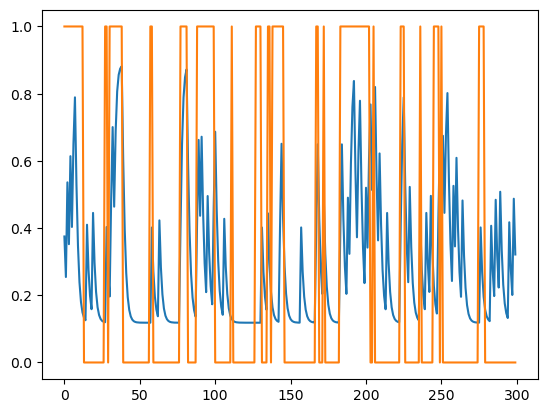

In [89]:
plt.plot(alpha[1,:])
plt.plot(true_x)

In [90]:
np.min(alpha)
alpha[1,48:50]

array([0.11946079, 0.11890715])

In [91]:
alpha_pred[:,0] = mu
alpha_unnorm = B[:,y[0]-1] * alpha_pred[:,0]
norm = alpha_unnorm.sum()
alpha[:,0] = alpha_unnorm/norm
marginals[0] = norm

In [92]:
for t in range(1, chain_length):
    alpha_pred[:,t] = A.T @ alpha[:,t-1]
    alpha_unnorm = B[:,y[t]-1] * alpha_pred[:,t]
    norm = alpha_unnorm.sum()
    alpha[:,t] = alpha_unnorm / norm
    marginals[t] = norm

In [93]:
y_null = np.sum(np.log(marginals))
print(y_null)

-530.5639706815869


In [94]:
y_alt = np.sum(np.log(marginals))

## Backward pass 

Compute smoothing distribution $p(x_t | y_{1:T})$.

From the forward pass, we have computed $\alpha_t(j) = p(x_t = j| y_{1:t})$ and $\alpha_{t|t-1}(j) = p(x_t = j | y_{1:t-1})$.

\begin{align}
p(x_t | y_{1:T}) &= \frac{p(x_t, y_t, y_{t+1:T} | y_{1:t-1})}{p(y_{t:T+1} | y_{1:t-1})} \\
&\propto p(y_{t+1:T} | x_t) p(y_t | x_t) p(x_t | y_{1:t-1}) \\
&= \beta_t(x_t) B_{x_t,y_t} \alpha_{t|t-1}(x_t).
\end{align}

We need a backward recursion to compute $\beta_t(x_t)$. 

\begin{align}
 p(y_{t+1:T} | x_t=i) &= \sum_{j=0}^{1} p(y_{t+1:T}, x_{t+1} = j | x_t=i) \\
 &= \sum_{j=0}^{1} p(y_{t+1} | x_{t+1} = j) p(y_{t+2:T} | x_{t+1}=j) p(x_{t+1} = j | x_t=i) \\
 &= \sum_{j=0}^{1} B_{j,y_{t+1}} \beta_{t+1}(j) A_{ij} \\
 &= A (B_{:,y_{t+1}} \odot \beta_{t+1}).
\end{align}

Base case $t = T$. Compute 

- Recursion: $\beta_T(j) = p(y_{T+1:T} | x_T) = p(\emptyset | x_T) = 1$.
- Smoothing: $p(x_T = j | y_{1:T}) \propto B_{j,y_T} \alpha_{T|T-1}(j)$.

For $t < T$. Compute,

- Recursion: $\beta_t(i) = p(y_{t+1:T} | x_t = i) = \sum_{j=0}^{1} B_{j,y_{t+1}} \beta_{t+1}(j) A_{ij}$.
- Smoothing: $p(x_t=i | y_{1:T}) \propto \beta_t(i) B_{i,y_t} \alpha_{t|t-1}(i)$.




In [95]:
beta = np.zeros((K, chain_length))
smoothing = np.zeros((K, chain_length))

In [96]:
beta[:,chain_length-1] = 1
smoothing_unnorm = beta[:,chain_length-1] * B[:,y[chain_length-1]-1] * alpha_pred[:,chain_length-1]
smoothing[:,chain_length-1] = smoothing_unnorm / smoothing_unnorm.sum()


In [97]:
print(smoothing[:,chain_length-1])
print(alpha[:,chain_length-1])

[0.67859214 0.32140786]
[0.67859214 0.32140786]


In [98]:
for t in reversed(range(chain_length-1)):
    beta[:,t] = A @ (B[:,y[t]-1] * beta[:,t+1])
    smoothing_unnorm = beta[:,t] * B[:,y[t]-1] * alpha_pred[:,t]
    smoothing[:,t] = smoothing_unnorm/smoothing_unnorm.sum()

In [99]:
print(alpha[:,chain_length-2])
print(smoothing[:,chain_length-2])


[0.51263848 0.48736152]
[0.32681516 0.67318484]


In [100]:
mse = np.mean((true_x - alpha[1,:])**2)
# Make prediction based on the filtering distribution.
filtering_x = np.argmax(alpha, axis=0)
filtering_accuracy = np.mean(np.abs(true_x == filtering_x))
print(mse)
print(filtering_accuracy)

0.17466524678695763
0.73


In [101]:
smoothing_mse = np.mean((true_x - smoothing[1,:])**2)
# Make prediction based on the smoothing distribution.
smoothing_x = np.argmax(smoothing, axis=0)
smoothing_accuracy = np.mean(np.abs(true_x == smoothing_x))
print(smoothing_mse)
print(smoothing_accuracy)

0.1593506344024201
0.7666666666666667


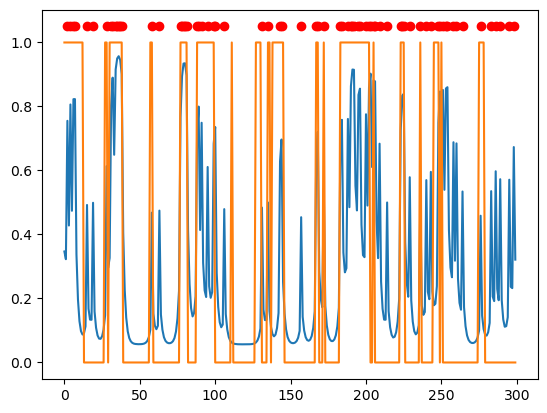

In [102]:
x_axis = np.arange(chain_length)
plt.plot(smoothing[1,:])
plt.plot(true_x)
ii = np.where(y == 6)
plt.plot(x_axis[ii], y[ii]/6 + 0.05, 'ro')